In [224]:
import sys
import subprocess
from pathlib import Path

repo_root = subprocess.run(
    ["git", "rev-parse", "--show-toplevel"], capture_output=True, text=True
).stdout.strip()

sys.path.append(repo_root)

In [225]:
import numpy as np

from tqdm import tqdm

from matplotlib import pyplot as plt

from modules import utils, fitting

import importlib
importlib.reload(utils)
importlib.reload(fitting)

utils.set_plot_configs()

In [226]:
class PendulumData:
    def __init__(self,data_file='final_measurements.txt'):
        self._read_data(data_file)
        self._analyse_all_bins()

    def _read_data(self,data_file):
        l = []
        Ts = []

        with open(data_file,'r') as f:
            for line in f.readlines():
                line_data = line.split()
                
                l.append(float(line_data[0]))
                Ts.append([
                    float(x)/10 for x in line_data[1:]
                ])

        self.l = np.array(l)
        self.Ts = np.array(Ts)

    def _analyse_single_bin(self,T):
        bayes_gaussian = fitting.BayesianGaussian(T)

        return bayes_gaussian.mu, bayes_gaussian.sigma, bayes_gaussian.chisqr, bayes_gaussian.alpha
    
    def _analyse_all_bins(self):
        self.T_mu = np.array([])
        self.T_sigma = np.array([])
        self.T_chisqr = np.array([])
        self.T_alpha = np.array([])

        for T in self.Ts:
            mu, sigma, chisqr, alpha = self._analyse_single_bin(T)

            self.T_mu = np.append(self.T_mu,mu)
            self.T_sigma = np.append(self.T_sigma,sigma)
            self.T_chisqr = np.append(self.T_chisqr,chisqr)
            self.T_alpha = np.append(self.T_alpha,alpha)

        self.T_reduced_chisqr = self.T_chisqr / self.Ts.shape[1]

In [227]:
pendulum_data = PendulumData()

print(pendulum_data.T_reduced_chisqr)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


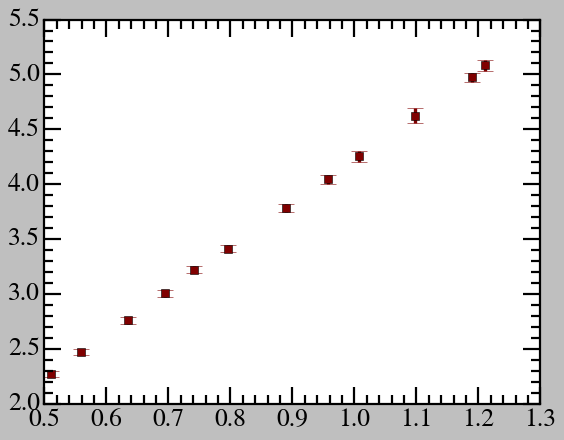

In [228]:
plt.errorbar(pendulum_data.l,pendulum_data.T_mu**2,yerr=2*pendulum_data.T_sigma*pendulum_data.T_mu,
             color='maroon',fmt=' s', markersize=7.5,elinewidth=3,capsize=7.5,)

plt.show()

In [229]:
class PendulumFitter(fitting.BaseFitter):
    def __init__(self,l,T,Terr):
        x = l
        y = (T/2/np.pi)**2
        yerr = 2 * (Terr/T) * y

        super().__init__(x,y,yerr)

    def _get_initial_guess(self):
        # l0, g
        return [0.05, 9.81]
    
    def _get_model(self,x,params):
        l0, g = params
        return (l0 + x)/g
    
pendulum_fitter = PendulumFitter(pendulum_data.l,pendulum_data.T_mu,pendulum_data.T_sigma)
fitting_result = pendulum_fitter.fit()

In [230]:
fitting_result

{'params': array([0.06004012, 9.8935284 ]),
 'e_params': array([0.01615835, 0.19649785]),
 'chisqr': 1.2850099764410285,
 'alpha': 0.9994635682374269,
 'cov': array([[0.00026109, 0.00309396],
        [0.00309396, 0.0386114 ]]),
 'success': True,
 'message': '`ftol` termination condition is satisfied.'}

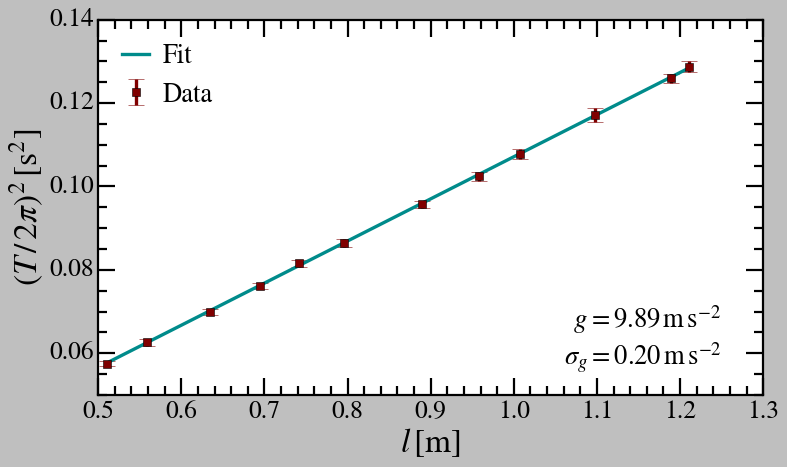

In [231]:
fig, ax = plt.subplots(figsize=(10,6))

ax.errorbar(pendulum_data.l, pendulum_data.T_mu**2/(2*np.pi)**2, yerr=2*pendulum_data.T_sigma*pendulum_data.T_mu/(2*np.pi)**2,
            fmt=' s', markersize=7.5,elinewidth=3,capsize=7.5,
            color='maroon',label='Data')

ax.plot(pendulum_data.l, pendulum_fitter._get_model(pendulum_data.l,fitting_result['params']),
        color='darkcyan',label='Fit')

ax.set_xlabel(r'$l\,[$m$]$')
ax.set_ylabel(r'$\left(T \, / \, 2\pi\right)^2 \, [$s$^2]$')

ax.legend(loc='upper left', ncol=1, handletextpad=0.5, handlelength=1.0, columnspacing=0.5, fontsize=24)

ax.text(0.7, 0.2, r' $\,g = $' + '%.2f'%fitting_result['params'][1] + r'$\,$m$\,$s$^{-2}$', transform=ax.transAxes, fontsize=24, rotation=0, horizontalalignment='left', verticalalignment='center')
ax.text(0.7, 0.1, r'$\sigma_g = $' + '%.2f'%fitting_result['e_params'][1] + r'$\,$m$\,$s$^{-2}$', transform=ax.transAxes, fontsize=24, rotation=0, horizontalalignment='left', verticalalignment='center')

plt.tight_layout()
plt.show()

In [232]:
class PendulumMCFitter:
    def __init__(self,l,T,Terr,N=1000):
        self.l = l
        self.T = T
        self.Terr = Terr

        self.delta_ls, self.l0s, self.gs, self.l0errs, self.gerrs, self.alphas = self._MC_fit(N)

    def _single_MC_fit(self):
        delta_l = np.random.uniform(-0.02,0.02,size=self.l.shape)

        pendulum_fitter = PendulumFitter(self.l + delta_l,self.T,self.Terr)
        fitting_result = pendulum_fitter.fit()

        return delta_l, *fitting_result['params'], *fitting_result['e_params'], fitting_result['alpha']
    
    def _MC_fit(self,N):
        delta_ls = []
        l0s = []
        gs = []
        l0errs = []
        gerrs = []
        alphas = []

        for _ in tqdm(range(N)):
            delta_l, l0, g, l0err, gerr, alpha = self._single_MC_fit()

            delta_ls.append(delta_l)
            l0s.append(l0)
            gs.append(g)
            l0errs.append(l0err)
            gerrs.append(gerr)
            alphas.append(alpha)

        return np.array(delta_ls), np.array(l0s), np.array(gs), np.array(l0errs), np.array(gerrs), np.array(alphas)

In [233]:
pendulum_MC_fitter = PendulumMCFitter(pendulum_data.l,pendulum_data.T_mu,pendulum_data.T_sigma,N=100000)

100%|██████████| 100000/100000 [01:57<00:00, 852.53it/s]


In [234]:
print(pendulum_MC_fitter.l0s.mean(),pendulum_MC_fitter.l0s.std())
print(pendulum_MC_fitter.gs.mean(),pendulum_MC_fitter.gs.std())

0.06047539742874509 0.014059401124689225
9.912426111193149 0.15424692165605858


In [235]:
max_alpha_idx = np.argmax(pendulum_MC_fitter.alphas)
print(pendulum_MC_fitter.gs[max_alpha_idx],pendulum_MC_fitter.gerrs[max_alpha_idx])

9.861698848795859 0.25922819876755737


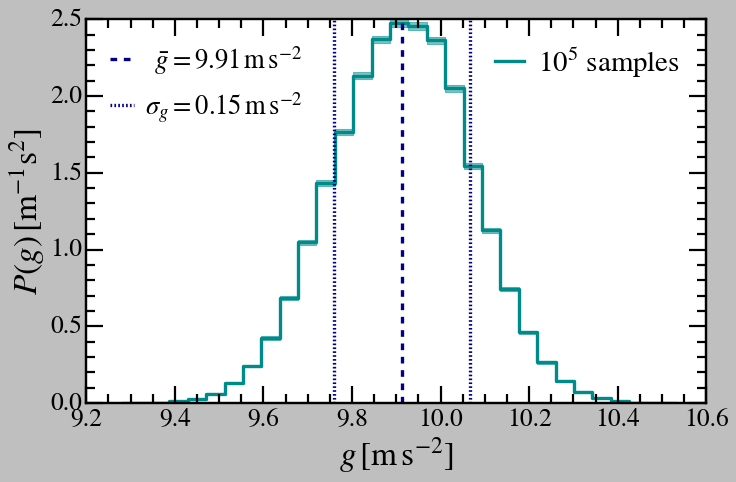

In [240]:
g_count, g_bins = np.histogram(pendulum_MC_fitter.gs,bins=31)
g_count_err = np.sqrt(g_count)
g_bin_centers = (g_bins[:-1] + g_bins[1:])/2

g_normalizer = np.sum(g_count) * (g_bin_centers[1] - g_bin_centers[0])
g_count = g_count / g_normalizer
g_count_err = g_count_err / g_normalizer

fig, ax = plt.subplots(figsize=(10,6))

ax.plot(g_bin_centers,g_count,drawstyle='steps-mid',color='darkcyan')
ax.fill_between(g_bin_centers,g_count-g_count_err,g_count+g_count_err,step='mid',color='darkcyan',alpha=0.5)

ax.axvline(pendulum_MC_fitter.gs.mean(),color='darkblue',linestyle='--',label=r' $\,\bar g = $' + f'{pendulum_MC_fitter.gs.mean():.2f}' + r'$\,$m$\,$s$^{-2}$')
ax.axvline(pendulum_MC_fitter.gs.mean() - pendulum_MC_fitter.gs.std(),color='darkblue',linestyle='--',dashes=(1.5,2),label=r'$\sigma_g = $' + f'{pendulum_MC_fitter.gs.std():.2f}' + r'$\,$m$\,$s$^{-2}$')
ax.axvline(pendulum_MC_fitter.gs.mean() + pendulum_MC_fitter.gs.std(),color='darkblue',linestyle='--',dashes=(1.5,2))

ax.set_xlabel(r'$g\,[$m$\,$s$^{-2}]$')
ax.set_ylabel(r'$P(g)\,[$m$^{-1}$s$^2]$')

ax.legend(loc='upper left', frameon=False, fontsize=24, ncol=1, handletextpad=0.4, handlelength=0.9, columnspacing=0.5)

ax_extra = ax.twinx()
ax_extra.plot([],[],drawstyle='steps-mid',color='darkcyan',label=r'$10^5$ samples')
ax_extra.legend(loc='upper right', frameon=False, fontsize=26, ncol=1, handletextpad=0.5, handlelength=1.0, columnspacing=0.5)
ax_extra.set_yticks([])
ax_extra.tick_params(axis='y', which='both',direction='in',right=False)
ax.tick_params(axis='both', which='both',direction='in',top=True,right=True)

plt.show()